In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, LabelBinarizer
from sklearn.model_selection import train_test_split

In [2]:
# check device
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda:0


In [3]:
# Load your data
df = pd.read_csv('../data/cleaned/cleaned_vessel_calls.csv')

In [4]:
# Preprocess the dataframe
df["arrivalDate"] = pd.to_datetime(df["arrivalDate"])
df["sailingDate"] = pd.to_datetime(df["sailingDate"])
df["duration"] = (df["sailingDate"] - df["arrivalDate"]) / pd.Timedelta(days=1)
df["month"] = df["arrivalDate"].dt.month
df = df.dropna()

In [5]:
# cap any outliers
cap = df['duration'].quantile(.99)
df['capped_duration'] = df['duration'].apply(lambda x: min(x, cap))

In [6]:
# Sort and filter data
df.sort_values(by=["IMO", "arrivalDate"], inplace=True)
df['next_unlocode'] = df.groupby('IMO')['place.unlocode'].shift(-1)
df['is_last_imo'] = df['IMO'] != df['IMO'].shift(-1)
df = df[~df["is_last_imo"]]
df = df[df["Event_Type"] != "ARRIVAL"]

In [7]:
# Drop unnecessary columns
df = df.drop(columns=["is_last_imo", "Event_Type", "Timestamp", "vessel.vesselName", "IMO", "arrivalDate", "sailingDate", "duration"])

# Rename columns for consistency
df = df.rename(columns={'place.unlocode': 'current_unlocode', 'place.placeName': 'port_name', 'vessel.vesselType': 'vessel_type', 'place.placeType': 'place_type', 'place.countryName': 'country_name'})

In [8]:
# Encode categorical features
label_encoders = {}
for column in ['port_name', 'country_name', 'vessel_type', 'place_type']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column].astype(str))
    label_encoders[column] = le

In [9]:
# One-hot encode the port_unlocode feature
lb_in = LabelBinarizer(sparse_output=False)
unlocode_onehot = lb_in.fit_transform(df[['current_unlocode']])
df_unlocode_onehot = pd.DataFrame(unlocode_onehot, columns=lb_in.classes_)

In [10]:
lb_y = LabelBinarizer(sparse_output=False)
y_onehot = lb_y.fit_transform(df[['next_unlocode']])

In [11]:
y_onehot_df = pd.DataFrame(y_onehot, columns=lb_y.classes_)

In [12]:
df

,port_name,current_unlocode,place_type,country_name,vessel_type,month,capped_duration,next_unlocode
314761,840,USLAX,1,163,4,1,7.579803,CNJGY
314763,658,CNJGY,1,104,4,2,1.484931,CNTXG
314765,1583,CNTXG,1,104,4,3,0.854514,CNQAW
314767,1279,CNQAW,2,104,4,3,0.613380,CNMSN
314769,908,CNMSN,2,104,4,3,1.021157,CNNSA
...,...,...,...,...,...,...,...,...
12569,1189,MYPKG,1,81,9,9,0.871701,INMAA
12571,290,INMAA,1,66,9,9,1.138021,BDCGP
12573,298,BDCGP,1,13,9,9,1.997604,THLCH
12575,789,THLCH,1,150,9,9,0.713912,SGSIN


In [13]:
# Add the one-hot encoded ports back to the dataframe
df = pd.concat([df.reset_index(drop=True), df_unlocode_onehot], axis=1)
df = df.drop(columns=['current_unlocode'])

In [14]:
# Prepare features
X = df.drop(columns=['next_unlocode'])
y = y_onehot

In [15]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Print dimensions after split
print(f"X_train shape: {X_train.shape}", f"y_train shape: {y_train.shape}", f"X_test shape: {X_test.shape}", f"y_test shape: {y_test.shape}")

X_train shape: (136601, 1778) y_train shape: (136601, 1771) X_test shape: (34151, 1778) y_test shape: (34151, 1771)


In [16]:
# Specify columns to scale
columns_to_scale = ['capped_duration', 'month', 'port_name', 'country_name', 'vessel_type', 'place_type']

# Initialize the scaler
scaler = MinMaxScaler()

# Fit the scaler on the training data
X_train_scaled_part = scaler.fit_transform(X_train[columns_to_scale])

# Transform the test data
X_test_scaled_part = scaler.transform(X_test[columns_to_scale])

# Convert the scaled data back to DataFrames
X_train_scaled_part = pd.DataFrame(X_train_scaled_part, columns=columns_to_scale, index=X_train.index)
X_test_scaled_part = pd.DataFrame(X_test_scaled_part, columns=columns_to_scale, index=X_test.index)

# Drop the columns to be scaled from the original DataFrames
X_train_unscaled_part = X_train.drop(columns=columns_to_scale)
X_test_unscaled_part = X_test.drop(columns=columns_to_scale)

print(X_train_scaled_part.shape, X_train_unscaled_part.shape)
print(X_test_scaled_part.shape, X_test_unscaled_part.shape)

# Concatenate the scaled and unscaled parts
X_train = pd.concat([X_train_scaled_part, X_train_unscaled_part], axis=1)
X_test = pd.concat([X_test_scaled_part, X_test_unscaled_part], axis=1)

# Verify the shapes after scaling
print("Shapes after MinMax scaling:")
print(f"X_train.shape: {X_train.shape}")
print(f"X_test.shape: {X_test.shape}")

(136601, 6) (136601, 1772)
(34151, 6) (34151, 1772)
Shapes after MinMax scaling:
X_train.shape: (136601, 1778)
X_test.shape: (34151, 1778)


In [17]:
X_train.shape

(136601, 1778)

In [18]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

In [19]:
# print of shapes of tensors
print(f"X_train_tensor shape: {X_train_tensor.shape}", f"y_train_tensor shape: {y_train_tensor.shape}", f"X_test_tensor shape: {X_test_tensor.shape}", f"y_test_tensor shape: {y_test_tensor.shape}")

X_train_tensor shape: torch.Size([136601, 1778]) y_train_tensor shape: torch.Size([136601, 1771]) X_test_tensor shape: torch.Size([34151, 1778]) y_test_tensor shape: torch.Size([34151, 1771])


In [20]:
# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [21]:
class PortPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_rate=0.5):
        super(PortPredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, 256, device=device)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.fc4 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.fc4(x)
        return x
    
input_size = X_train_tensor.shape[1]
num_classes = y_train_tensor.shape[1]
hidden_size = 128

# TODO: Play around with the loss function and learning rate - you want it to fluctuate. Goal is to minimize the loss
model = PortPredictor(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # StepLR scheduler

In [22]:
X_train_tensor.shape

torch.Size([136601, 1778])

In [23]:
X_train_tensor

tensor([[0.1373, 0.0000, 0.0460,  ..., 0.0000, 0.0000, 0.0000],
        [0.2286, 0.6364, 0.0023,  ..., 0.0000, 0.0000, 0.0000],
        [0.0402, 0.6364, 0.8348,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.1566, 0.8182, 0.2737,  ..., 0.0000, 0.0000, 0.0000],
        [0.2637, 0.4545, 0.0346,  ..., 0.0000, 0.0000, 0.0000],
        [0.0604, 0.1818, 0.4974,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0')

In [24]:
model

PortPredictor(
  (fc1): Linear(in_features=1778, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=128, out_features=256, bias=True)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=256, out_features=1771, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [25]:
# Lists to store loss and accuracy
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

def train_model():
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, torch.argmax(targets, dim=1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        target_classes = torch.argmax(targets, dim=1)
        correct += (predicted == target_classes).sum().item()
        total += target_classes.size(0)
        
    accuracy = correct / total
    return total_loss / len(train_loader), accuracy

def test_model():
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, torch.argmax(targets, dim=1))
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            target_classes = torch.argmax(targets, dim=1)
            correct += (predicted == target_classes).sum().item()
            total += target_classes.size(0)
            
    accuracy = correct / total
    return total_loss / len(test_loader), accuracy

In [26]:
num_epochs = 50

for epoch in range(num_epochs):
    train_loss, train_acc = train_model()
    test_loss, test_acc = test_model()
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
    scheduler.step()

Epoch 0, Train Loss: 4.9645, Train Acc: 0.1066, Test Loss: 4.1165, Test Acc: 0.1746
Epoch 1, Train Loss: 4.2812, Train Acc: 0.1441, Test Loss: 3.8411, Test Acc: 0.1899
Epoch 2, Train Loss: 4.0958, Train Acc: 0.1564, Test Loss: 3.7229, Test Acc: 0.2005
Epoch 3, Train Loss: 3.9966, Train Acc: 0.1628, Test Loss: 3.6621, Test Acc: 0.2047
Epoch 4, Train Loss: 3.9376, Train Acc: 0.1690, Test Loss: 3.6167, Test Acc: 0.2106
Epoch 5, Train Loss: 3.8942, Train Acc: 0.1720, Test Loss: 3.5696, Test Acc: 0.2129
Epoch 6, Train Loss: 3.8656, Train Acc: 0.1750, Test Loss: 3.5522, Test Acc: 0.2158
Epoch 7, Train Loss: 3.8334, Train Acc: 0.1788, Test Loss: 3.5320, Test Acc: 0.2201
Epoch 8, Train Loss: 3.8182, Train Acc: 0.1820, Test Loss: 3.5168, Test Acc: 0.2199
Epoch 9, Train Loss: 3.7975, Train Acc: 0.1820, Test Loss: 3.5056, Test Acc: 0.2235
Epoch 10, Train Loss: 3.7449, Train Acc: 0.1884, Test Loss: 3.4810, Test Acc: 0.2270
Epoch 11, Train Loss: 3.7271, Train Acc: 0.1899, Test Loss: 3.4743, Test Ac

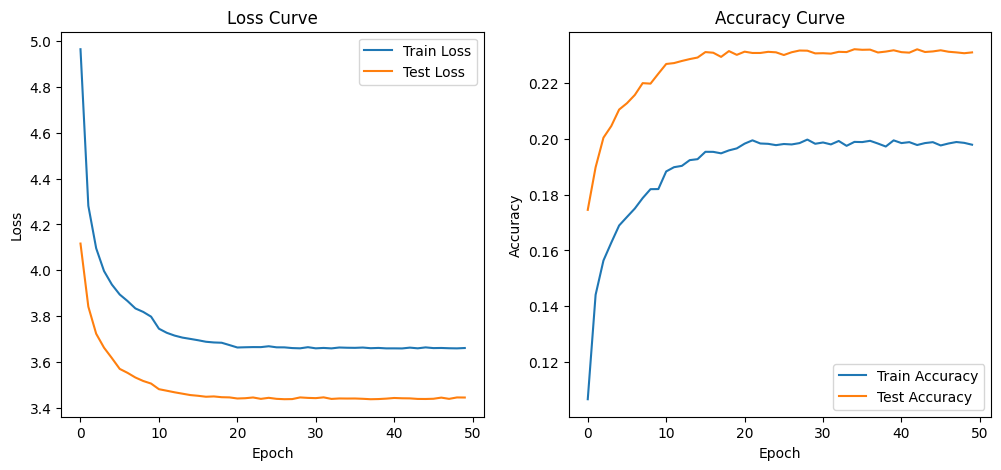

In [27]:
# Plot learning curves
plt.figure(figsize=(12, 5))

# Plot training and test loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Plot training and test accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()